In [0]:
from google.colab import drive
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings
from ast import literal_eval
import ast
warnings.filterwarnings('ignore')
%matplotlib inline


warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('max_colwidth', 40)
%matplotlib inline

In [0]:
import os
import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud as wc
import scipy.sparse as sparse
import xgboost as xgb
import sklearn

from xgboost import XGBRegressor
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold,train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
saving=False


In [13]:
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
fp1 = '/content/drive/My Drive/movies/credits.csv'

fp2 = '/content/drive/My Drive/movies/keywords.csv'

fp3 = '/content/drive/My Drive/movies/links_small.csv'

fp4 = '/content/drive/My Drive/movies/links.csv'

fp5 = '/content/drive/My Drive/movies/movies_metadata.csv'

fp6 = '/content/drive/My Drive/movies/ratings_small.csv'

fp7 = '/content/drive/My Drive/movies/ratings.csv'



In [0]:
credits = pd.read_csv(fp1)
keyword = pd.read_csv(fp2)
linksmall = pd.read_csv(fp3)
link = pd.read_csv(fp4)
metadata = pd.read_csv(fp5) 
ratingsmall = pd.read_csv(fp6)
ratings = pd.read_csv(fp7)


In [17]:
metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Col...",30000000,"[{'id': 16, 'name': 'Animation'}, {'...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happi...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios',...","[{'iso_3166_1': 'US', 'name': 'Unite...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'Englis...",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discove...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': ...","[{'iso_3166_1': 'US', 'name': 'Unite...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'Englis...",Released,Roll the dice and unleash the excite...,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old M...",0,"[{'id': 10749, 'name': 'Romance'}, {...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancie...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194...","[{'iso_3166_1': 'US', 'name': 'Unite...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'Englis...",Released,Still Yelling. Still Fighting. Still...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id'...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped o...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Fil...,"[{'iso_3166_1': 'US', 'name': 'Unite...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'Englis...",Released,Friends are the people who let you b...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', '...","[{'iso_3166_1': 'US', 'name': 'Unite...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'Englis...",Released,Just When His World Is Back To Norma...,Father of the Bride Part II,False,5.7,173.0



# helper functions

In [0]:

def group_indices(series,index="id"):
    d={}
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:
            d.setdefault(x[index],[])
            d[x[index]].append(i)
    return d

def get_groups(series,index="name"):
    s=set()
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:s.add(x[index])
    return list(s)

def multi_count(series,index="id"):
    return {k:len(v) for (k,v) in group_indices(series,index).items()}



def multi_groupby(df,column,index="id"):
    return expand_multi_feature(df,column,index).groupby(column)
  
  




# WordCloud of the given Genres 

In [0]:
def multi_wordcloud(series,filename):
    w=wc.WordCloud(background_color="black",margin=20,width=800,height=600,prefer_horizontal=0.7,max_words=50,scale=2)
    count=multi_count(series,"name")
    w.generate_from_frequencies(count)
    if saving:w.to_file(filename)
    f, ax = plt.subplots(figsize=(16, 16))
    plt.axis('off')
    plt.imshow(w)
    plt.show()


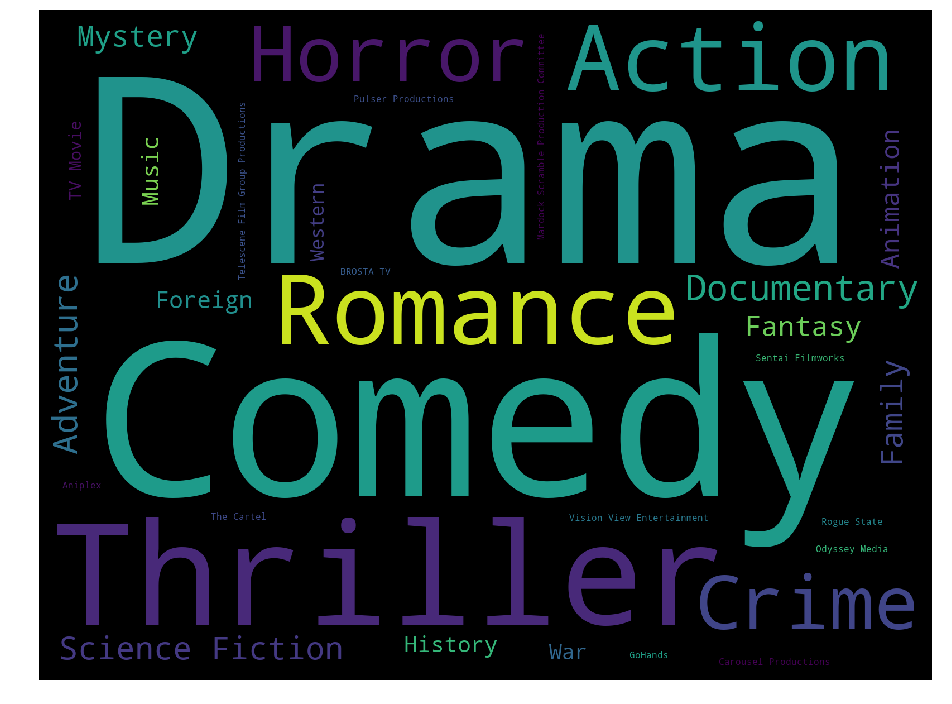

In [20]:
multi_wordcloud(metadata.genres,filename="wordcloud_genres.png")


In [0]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [0]:
genre_labels = set()
for s in metadata['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))


In [23]:
keyword_occurences, dum = count_word(metadata, 'genres', genre_labels)
keyword_occurences[:5]


[["[{'id': 18, 'name': 'Drama'}]", 5000],
 ["[{'id': 35, 'name': 'Comedy'}]", 3621],
 ["[{'id': 99, 'name': 'Documentary'}]", 2723],
 ['[]', 2442],
 ["[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]", 1301]]

In [24]:
# Statistical details on Movie id
stats = ratings.groupby(['userId','movieId']).agg({'rating': [min, max, 'mean', 'count', 'std','var']}).reset_index()
stats.head(5)

userId movieId rating                        
                    min  max mean count std var
0      1     110    1.0  1.0  1.0     1 NaN NaN
1      1     147    4.5  4.5  4.5     1 NaN NaN
2      1     858    5.0  5.0  5.0     1 NaN NaN
3      1    1221    5.0  5.0  5.0     1 NaN NaN
4      1    1246    5.0  5.0  5.0     1 NaN NaN

In [25]:
data = pd.merge(credits, keyword, on='id') 
data.head() 


,cast,crew,id,keywords
0,"[{'cast_id': 14, 'character': 'Woody...",[{'credit_id': '52fe4284c3a36847f802...,862,"[{'id': 931, 'name': 'jealousy'}, {'..."
1,"[{'cast_id': 1, 'character': 'Alan P...",[{'credit_id': '52fe44bfc3a36847f80a...,8844,"[{'id': 10090, 'name': 'board game'}..."
2,"[{'cast_id': 2, 'character': 'Max Go...",[{'credit_id': '52fe466a9251416c7507...,15602,"[{'id': 1495, 'name': 'fishing'}, {'..."
3,"[{'cast_id': 1, 'character': ""Savann...",[{'credit_id': '52fe44779251416c9101...,31357,"[{'id': 818, 'name': 'based on novel..."
4,"[{'cast_id': 1, 'character': 'George...",[{'credit_id': '52fe44959251416c7503...,11862,"[{'id': 1009, 'name': 'baby'}, {'id'..."


# Data Cleaning: Handling Missing Data


In [26]:
metadata.info()

metadata[metadata['title'].isnull()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19729,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id'...",NaN,82663,tt0113002,en,Midnight Man,British soldiers force a recently ca...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'i...","[{'iso_3166_1': 'CA', 'name': 'Canad...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'Englis...",Released,NaN,Midnight Man,False,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29502,False,"{'id': 122661, 'name': 'Mardock Scra...",0,"[{'id': 16, 'name': 'Animation'}, {'...",http://m-scramble.jp/exhaust/,122662,tt2423504,ja,マルドゥック・スクランブル 排気,Third film of the Mardock Scramble s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connect...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'...","[{'iso_3166_1': 'US', 'name': 'Unite...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Mardock Scramble: The Third Exhaust,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35586,False,NaN,0,"[{'id': 10770, 'name': 'TV Movie'}, ...",NaN,249260,tt2622826,en,Avalanche Sharks,A group of skiers are terrorized dur...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 171...","[{'iso_3166_1': 'CA', 'name': 'Canad...",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'Englis...",Released,Beware Of Frost Bites,Avalanche Sharks,False,4.3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Remove null titles from original titles

In [27]:
metadata = metadata[pd.notnull(metadata['title'])]

metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45460 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45460 non-null object
belongs_to_collection    4490 non-null object
budget                   45460 non-null object
genres                   45460 non-null object
homepage                 7778 non-null object
id                       45460 non-null object
imdb_id                  45443 non-null object
original_language        45449 non-null object
original_title           45460 non-null object
overview                 44506 non-null object
popularity               45460 non-null object
poster_path              45077 non-null object
production_companies     45460 non-null object
production_countries     45460 non-null object
release_date             45376 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

### Make boolean field

In [28]:
# We try to keep this as a boolean field
metadata.loc[(metadata['adult'] != 'True') & (metadata['adult'] != 'False'), 'adult'] = False
metadata['adult'] = metadata['adult'].map({'True': True, 'False': False})
metadata['adult'].value_counts()


False    45451
True         9
Name: adult, dtype: int64

In [29]:
metadata['adult'].unique()

array([False,  True])

 We want to convert belongs to collection to boolean value

In [0]:

metadata['belongs_to_collection'] = metadata['belongs_to_collection'].notna()

In [0]:

# Function to convert string objects using the library literaty_eval 

def get_values(data_str):
    if isinstance(data_str, float):
        pass
    else:
        values = []
        data_str = ast.literal_eval(data_str)
        if isinstance(data_str, list):
            for k_v in data_str:
                values.append(k_v['name'])
            return values
        else:
            return None

In [35]:
# Dictionary to lists
metadata[['production_companies', 'production_countries', 'spoken_languages']] = metadata[['production_companies', 'production_countries', 'spoken_languages']].applymap(get_values)

ValueError: ignored

In [0]:
#release_date
metadata['release_date'] = pd.to_datetime(metadata['release_date'], format = '%Y-%m-%d', errors='coerce')

Budget and Revenue have 0 values instead of NaN
Idea is to create a new metric called Profit to consider it as a factor to better understand its relation to movie ratings

In [37]:
display(metadata[metadata['budget'] == '0']['budget'].count(),  # lots of null values
        metadata[metadata['revenue'] == 0]['revenue'].count())

36570

38052

In [0]:
# Converts budget to float datatype
metadata['budget'] = pd.to_numeric(metadata['budget'], errors = 'coerce')

# replace 0 values with NaN
metadata.loc[(metadata['budget'] == 0) & (metadata['revenue'] == 0), 'revenue'] = np.nan
metadata.loc[metadata['budget'] == 0, 'budget'] = np.nan

In [0]:
metadata['id'] = metadata['id'].astype(int)

In [0]:
metadata = metadata.merge(keyword, on='id')

In [41]:
metadata.columns


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'keywords'],
      dtype='object')

# Now here comes the  Most important part of the recommendation **system**

In [42]:
metadata['overview'].head()

0    Led by Woody, Andy's toys live happi...
1    When siblings Judy and Peter discove...
2    A family wedding reignites the ancie...
3    Cheated on, mistreated and stepped o...
4    Just when George Banks has recovered...
Name: overview, dtype: object

# #Replace NaN with an empty string

In [0]:

metadata['overview'] = metadata['overview'].fillna('')


# Lets convert it into String to perform all operations

In [0]:
metadata['overview']=metadata['overview'].astype(str)

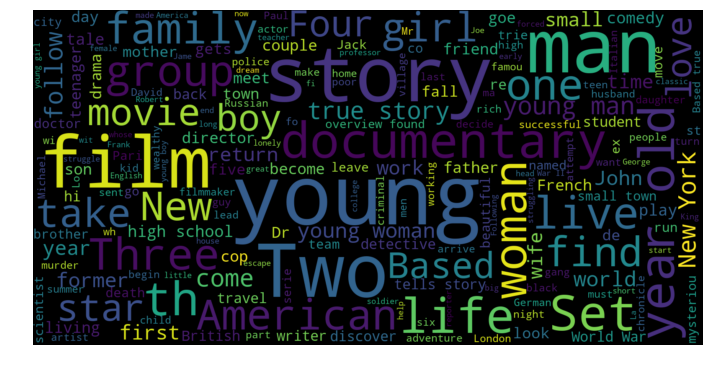

In [45]:
from wordcloud import WordCloud

text = metadata['overview'].to_string()

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Removal of Stop Words
As we discussed earlier, stop words (or commonly occurring words) should be removed from the text data. For this purpose, we can either create a list of stopwords ourselves or we can use predefined libraries.

In [46]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Count of Stopwords

In [47]:
from nltk.corpus import stopwords
stop = stopwords.words('english')


metadata['stopwords'] = metadata['overview'].apply(lambda x: len([x for x in x.split() if x in stop]))
metadata[['overview','stopwords']].head()

,overview,stopwords
0,"Led by Woody, Andy's toys live happi...",16
1,When siblings Judy and Peter discove...,25
2,A family wedding reignites the ancie...,20
3,"Cheated on, mistreated and stepped o...",16
4,Just when George Banks has recovered...,29


we will remove stopwords when we use tfid function which will come ahead but first lets complete preprocessing

In [0]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer





# Lower case

The first pre-processing step which we will do is transform our texts into lower case. This avoids having multiple copies of the same words. For example, while calculating the word count, ‘Sentiment’ and ‘sentiment’ will be taken as different words. **bold text** 

In [49]:
metadata['overview'] = metadata['overview'].apply(lambda x: " ".join(x.lower() for x in x.split()))
metadata['overview'].head(5)

0    led by woody, andy's toys live happi...
1    when siblings judy and peter discove...
2    a family wedding reignites the ancie...
3    cheated on, mistreated and stepped o...
4    just when george banks has recovered...
Name: overview, dtype: object

# Number of numerics
**Just like we calculated the number of words, we can also calculate the number of numerics which are present in the overview. It does not have a lot of use in our example, but this is still a useful feature that should be run while doing similar exercises. For example,**

In [50]:
metadata['numerics'] = metadata['overview'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
metadata[['overview','numerics']].head(5)

,overview,numerics
0,"led by woody, andy's toys live happi...",0
1,when siblings judy and peter discove...,1
2,a family wedding reignites the ancie...,0
3,"cheated on, mistreated and stepped o...",0
4,just when george banks has recovered...,0


# Removing Punctuation
The next step is to remove punctuation, as it doesn’t add any extra information while treating text data. Therefore removing all instances of it will help us reduce the size of the training data.

In [51]:
metadata['overview'] = metadata['overview'].str.replace('[^\w\s]','')
metadata['overview'].head()

0    led by woody andys toys live happily...
1    when siblings judy and peter discove...
2    a family wedding reignites the ancie...
3    cheated on mistreated and stepped on...
4    just when george banks has recovered...
Name: overview, dtype: object

# Common Word Removal

In [65]:
freq = pd.Series(' '.join(metadata['overview']).split()).value_counts()[:10]
freq

he       20914
for      18760
on       17851
an       17199
by       16196
that     15767
as       15087
who      14729
their    13479
from     12854
dtype: int64

In [66]:
freq 
metadata['overview'] = metadata['overview'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
metadata['overview'].head(5)

0    led woody andys toys live happily ro...
1    when siblings judy peter discover en...
2    family wedding reignites ancient feu...
3    cheated mistreated stepped women are...
4    just when george banks has recovered...
Name: overview, dtype: object

Rare words removal

In [67]:
freq1 = pd.Series(' '.join(metadata['overview']).split()).value_counts()[-10:]
freq1

exoskeleton    1
clincher       1
nips           1
brownies       1
goetze         1
φέρνει         1
backroads      1
lakshmis       1
utaemon        1
damiaan        1
dtype: int64

In [74]:
metadata['overview'] = metadata['overview'].apply(lambda x: " ".join(x for x in x.split() if x not in freq1))
metadata['overview'].head(5)

0    led woody andys toys live happily ro...
1    when siblings judy peter discover en...
2    family wedding reignites ancient feu...
3    cheated mistreated stepped women are...
4    just when george banks has recovered...
Name: overview, dtype: object

# Spelling correction

In [75]:
from textblob import TextBlob
metadata['overview'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    led wood andy toys live happily room...
1    when shillings judy peter discover e...
2    family wedding reignites ancient fed...
3    created mistreated stepped women are...
4    just when george banks has recovered...
Name: overview, dtype: object

#Tokenization

Tokenization refers to dividing the text into a sequence of words or sentences. In our example, we have used the textblob library to first transform our text into a blob and then converted them into a series of words.

In [76]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [77]:
TextBlob(metadata['overview'][1]).words

WordList(['when', 'siblings', 'judy', 'peter', 'discover', 'enchanted', 'board', 'game', 'opens', 'door', 'magical', 'world', 'they', 'unwittingly', 'invite', 'alan', 'adult', 'whos', 'been', 'trapped', 'inside', 'game', '26', 'years', 'into', 'living', 'room', 'alans', 'only', 'hope', 'freedom', 'finish', 'game', 'which', 'proves', 'risky', 'all', 'three', 'find', 'themselves', 'running', 'giant', 'rhinoceroses', 'evil', 'monkeys', 'other', 'terrifying', 'creatures'])

In [78]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [79]:
from textblob import Word
metadata['ovrview'] = metadata['overview'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
metadata['overview'].head()

0    led woody andys toys live happily ro...
1    when siblings judy peter discover en...
2    family wedding reignites ancient feu...
3    cheated mistreated stepped women are...
4    just when george banks has recovered...
Name: overview, dtype: object

Removing Punctuations from Keywords

In [80]:
metadata['keywords'] = metadata['keywords'].str.replace('[^\w\s]','')
metadata['keywords'].head()

0    id 931 name jealousy id 4290 name to...
1    id 10090 name board game id 10941 na...
2    id 1495 name fishing id 12392 name b...
3    id 818 name based on novel id 10131 ...
4    id 1009 name baby id 1599 name midli...
Name: keywords, dtype: object

In [81]:
tf1 = (metadata['overview'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,game,3
1,themselves,1
2,trapped,1
3,opens,1
4,evil,1
5,finish,1
6,giant,1
7,discover,1
8,find,1
9,hope,1


In [82]:
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(metadata.shape[0]/(len(metadata[metadata['overview'].str.contains(word)])))

tf1

,words,tf,idf
0,game,3,3.978241
1,themselves,1,3.816240
2,trapped,1,4.747798
3,opens,1,5.494461
4,evil,1,3.622256
5,finish,1,5.253673
6,giant,1,5.094245
7,discover,1,2.780148
8,find,1,2.017661
9,hope,1,3.803612


In [83]:

tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,game,3,3.978241,11.934723
1,themselves,1,3.816240,3.816240
2,trapped,1,4.747798,4.747798
3,opens,1,5.494461,5.494461
4,evil,1,3.622256,3.622256
5,finish,1,5.253673,5.253673
6,giant,1,5.094245,5.094245
7,discover,1,2.780148,2.780148
8,find,1,2.017661,2.017661
9,hope,1,3.803612,3.803612


In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(metadata['overview'])
train_vect


<46478x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 555183 stored elements in Compressed Sparse Row format>

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(metadata['overview'])
train_bow

<46478x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 832589 stored elements in Compressed Sparse Row format>

In [86]:
import random
ran = random.randint(25000, 30000)
df = metadata.head(ran)
tfidf_matrix = tfidf.fit_transform(df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(27569, 1000)

In [0]:

from sklearn.metrics.pairwise import linear_kernel
cosine_sim =  linear_kernel(tfidf_matrix, tfidf_matrix, True)

In [0]:
indices = pd.Series(df.index, index=df['title']).drop_duplicates()


In [0]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [90]:
get_recommendations("Harry Potter and the Philosopher's Stone")


3234                              Born Yesterday
23577                                        Luv
10593        Harry Potter and the Goblet of Fire
7144                               Love at Large
3962                    Harry, He's Here To Help
4387                               The Dead Pool
17072                                 Crazy Love
17511    Harry Potter and the Deathly Hallows...
26908                                 Long Pants
10425              The Greatest Game Ever Played
Name: title, dtype: object

In [91]:
keyword.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
id          46419 non-null int64
keywords    46419 non-null object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [0]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46478 entries, 0 to 46477
Data columns (total 28 columns):
adult                    46478 non-null bool
belongs_to_collection    46478 non-null bool
budget                   9011 non-null float64
genres                   46478 non-null object
homepage                 7985 non-null object
id                       46478 non-null int64
imdb_id                  46461 non-null object
original_language        46467 non-null object
original_title           46478 non-null object
overview                 46478 non-null object
popularity               46478 non-null object
poster_path              46083 non-null object
production_companies     46478 non-null object
production_countries     46478 non-null object
release_date             46394 non-null datetime64[ns]
revenue                  11074 non-null float64
runtime                  46214 non-null float64
spoken_languages         46478 non-null object
status                   46396 non-null o

In [0]:
keyword['id']=keyword['id'].astype(object)

In [0]:
metadata= metadata.merge(keyword, on='id')

In [0]:
metadata= metadata.merge(credits, on='id')

In [101]:
metadata.head(4)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords_x,stopwords,numerics,ovrview,keywords_y,cast_x,crew_x,cast_y,crew_y
0,False,True,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,led woody andys toys live happily ro...,21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,id 931 name jealousy id 4290 name to...,16,0,led woody andys toy live happily roo...,"[{'id': 931, 'name': 'jealousy'}, {'...","[{'cast_id': 14, 'character': 'Woody...",[{'credit_id': '52fe4284c3a36847f802...,"[{'cast_id': 14, 'character': 'Woody...",[{'credit_id': '52fe4284c3a36847f802...
1,False,False,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'...",NaN,8844,tt0113497,en,Jumanji,when siblings judy peter discover en...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Int...",[United States of America],1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excite...,Jumanji,False,6.9,2413.0,id 10090 name board game id 10941 na...,25,1,when sibling judy peter discover enc...,"[{'id': 10090, 'name': 'board game'}...","[{'cast_id': 1, 'character': 'Alan P...",[{'credit_id': '52fe44bfc3a36847f80a...,"[{'cast_id': 1, 'character': 'Alan P...",[{'credit_id': '52fe44bfc3a36847f80a...
2,False,True,NaN,"[{'id': 10749, 'name': 'Romance'}, {...",NaN,15602,tt0113228,en,Grumpier Old Men,family wedding reignites ancient feu...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,NaN,101.0,[English],Released,Still Yelling. Still Fighting. Still...,Grumpier Old Men,False,6.5,92.0,id 1495 name fishing id 12392 name b...,20,0,family wedding reignites ancient feu...,"[{'id': 1495, 'name': 'fishing'}, {'...","[{'cast_id': 2, 'character': 'Max Go...",[{'credit_id': '52fe466a9251416c7507...,"[{'cast_id': 2, 'character': 'Max Go...",[{'credit_id': '52fe466a9251416c7507...
3,False,False,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id'...",NaN,31357,tt0114885,en,Waiting to Exhale,cheated mistreated stepped women are...,3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[Twentieth Century Fox Film Corporat...,[United States of America],1995-12-22,81452156.0,127.0,[English],Released,Friends are the people who let you b...,Waiting to Exhale,False,6.1,34.0,id 818 name based on novel id 10131 ...,16,0,cheated mistreated stepped woman are...,"[{'id': 818, 'name': 'based on novel...","[{'cast_id': 1, 'character': 'Savann...",[{'credit_id': '52fe44779251416c9101...,"[{'cast_id': 1, 'character': ""Savann...",[{'credit_id': '52fe44779251416c9101...
